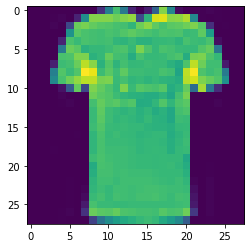

[Epoch:001] train loss: 0.36449 train accuracy: 0.8710 | valid loss: 0.29209 valid accuracy: 0.8923
[Epoch:002] train loss: 0.24011 train accuracy: 0.9128 | valid loss: 0.23985 valid accuracy: 0.9152
[Epoch:003] train loss: 0.20010 train accuracy: 0.9276 | valid loss: 0.21999 valid accuracy: 0.9215
[Epoch:004] train loss: 0.17228 train accuracy: 0.9389 | valid loss: 0.21819 valid accuracy: 0.9206
[Epoch:005] train loss: 0.15090 train accuracy: 0.9456 | valid loss: 0.24561 valid accuracy: 0.9129
[Epoch:006] train loss: 0.12835 train accuracy: 0.9537 | valid loss: 0.20655 valid accuracy: 0.9260
[Epoch:007] train loss: 0.11198 train accuracy: 0.9592 | valid loss: 0.21891 valid accuracy: 0.9266
[Epoch:008] train loss: 0.09425 train accuracy: 0.9659 | valid loss: 0.22002 valid accuracy: 0.9266
[Epoch:009] train loss: 0.08048 train accuracy: 0.9718 | valid loss: 0.22532 valid accuracy: 0.9292
[Epoch:010] train loss: 0.06785 train accuracy: 0.9753 | valid loss: 0.25542 valid accuracy: 0.9244


In [13]:
import torch
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
%matplotlib inline

# Dataset Class
class FashionMnist(Dataset):
    def __init__(self, data_path, is_train=True):
        filename = os.path.join(data_path, 'fashion-mnist_train.csv' if is_train else 'fashion-mnist_test.csv')
        assert os.path.exists(filename), 'File not found error'
        self.is_train = is_train
        self.data = pd.read_csv(filename)
        self.data = self.data.sort_values(by=['label']).to_numpy(dtype=np.float32)
        self.data_y = self.data[:, 0].astype(np.int)
        self.data_x = self.data[:, 1:]
        self.data_shape = (28, 28)
        self.transform = transforms.Compose( ## augmentation은 필요없는 것 같습니다
            [
                # transforms.ToPILImage(),
                # transforms.Grayscale(1), ## augmentation 없애기 전에 에러나서 넣었어요
                # transforms.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),
                # transforms.RandomHorizontalFlip(p=0.5),
                # transforms.RandomVerticalFlip(p=0.5),
                # transforms.RandomRotation(75)
                
            ]
        )

    def __len__(self):
        return len(self.data_y)

    def __getitem__(self, index):
        ret_x = np.reshape(self.data_x[index], self.data_shape)
        if self.is_train: # augmentation
            ret_x = self.transform(ret_x)
        ret_x = transforms.ToTensor()(np.array(ret_x)) ## test dataset도 텐서로 바꿔줘야해서 따로 빼줬습니다
        ret_y = self.data_y[index]
        return {
            'data_x': ret_x,
            'data_y': ret_y
        }

# Model Class
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential( ## 일반적인 순서
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
    
    def forward(self, tensor):
        return self.block(tensor)
    
class BasicModel(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(BasicModel, self).__init__()
        k = 32
        self.block = nn.Sequential(
            ConvBlock(in_channel, k),
            ConvBlock(k, k*2),
            ConvBlock(k*2, k*4),
            ConvBlock(k*4, k*2)
        )
        self.linear = nn.Linear(k*2, num_classes)
    
    def forward(self, tensor):
        out = self.block(tensor)
        out = out.view(-1, out.size(1))
        return self.linear(out)
 

def main():
    batch_size = 100 ## 3은 너무 작아서 batch norm 못써요
    epoch = 30 ## 너무 많이 안했어요
    learning_rate = 1e-3 ## adam 기본값이 0.001 이네요
    in_channel = 1 ## 원래 한 개인가? 데이터가 한 개네요
    num_classes = 10
    betas = (0.9, 0.999) ## 보통 0.9 0.999 라서
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_dataset = FashionMnist('./drive/My Drive/Colab Data/Fashion_MNIST', True)
    valid_dataset = FashionMnist('./drive/My Drive/Colab Data/Fashion_MNIST', False)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, pin_memory=True, num_workers=4, shuffle=True)## 셔플 추가
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, drop_last=False, pin_memory=True, num_workers=4)

    model = BasicModel(in_channel=in_channel, num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss() # Binary Cross Entropy Loss ## 바꿨어요 ㅋㅋ
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=betas)

    ##첫 데이터 출력
    plt.imshow(np.asarray(train_dataset[0]['data_x']).reshape(28,28))
    plt.show()
    ##

    for ep in range(epoch):
        # train
        avg_loss = 0
        avg_acc = 0
         
        model.train() ##train mode
        count = 0
        for batch in train_loader: ## idx 삭제
            optim.zero_grad()
            batch_x = batch['data_x'].to(device) #데이터 GPU로
            batch_y = batch['data_y'].to(device)
            if ep == 0:
              for x in batch_y:
                class_num[x.item()]+=1
            output = model(batch_x)
            # print(output)
            # print(batch_y)
            # print(output.size())
            # print(batch_y.size())
            loss = criterion(output, batch_y)
            avg_loss += loss.item()

            # cal accuracy
            _, index = torch.max(output, 1)
            avg_acc += (index == batch_y).sum().float() / len(batch_y)
            count += 1

            loss.backward()
            optim.step()

        avg_loss /= count
        avg_acc /= count
        ##기록 저장
        loss_list.append(avg_loss)
        acc_list.append(avg_acc)

        # valid
        avg_test_loss = 0
        avg_test_acc = 0

        count = 0
        model.eval() ## test mode
        with torch.no_grad(): ## 계산 빨리하기
          for batch in valid_loader: #여기도 idx 삭제
              #optim.zero_grad() ##test에서 할 필요 없음
              batch_x = batch['data_x'].to(device) #데이터 GPU에 올리기
              batch_y = batch['data_y'].to(device)
              output = model(batch_x)

              loss = criterion(output, batch_y)
              avg_test_loss += loss.item()

              # cal accuracy
              _, index = torch.max(output, 1)
              avg_test_acc += (index == batch_y).sum().float() / len(batch_y)
              count += 1

        avg_test_loss /= count
        avg_test_acc /= count
        ## 기록 저장
        test_loss.append(avg_test_loss)
        test_acc.append(avg_test_acc)
        epoch_list.append(ep+1)

        print("[Epoch:%03d] train loss: %.5f train accuracy: %.4f | valid loss: %.5f valid accuracy: %.4f"
              % (ep+1, avg_loss, avg_acc, avg_test_loss, avg_test_acc))

    print("Training Done.")

def save_model(model):
  PATH
  torch.save(model,)
if __name__ == "__main__":
    class_num = [0]*10
    loss_list,acc_list,test_loss,test_acc = [],[],[],[] ## 기록 저장 리스트
    epoch_list = [] 
    main()

## 클래스 별 데이터 수 & 그래프 그리기



Balance Checking
Label:  0 6000
Label:  1 6000
Label:  2 6000
Label:  3 6000
Label:  4 6000
Label:  5 6000
Label:  6 6000
Label:  7 6000
Label:  8 6000
Label:  9 6000


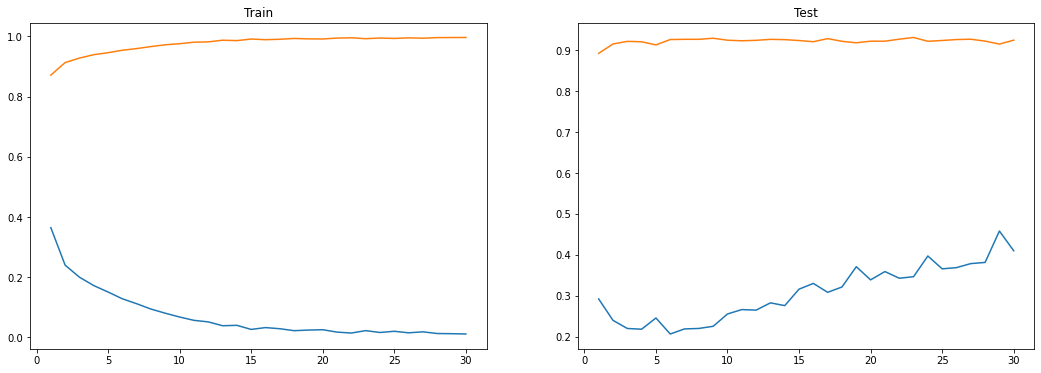

In [14]:
print("Balance Checking")
for label, C in enumerate(class_num):
  print("Label: ", label, C)

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(epoch_list,loss_list)
plt.plot(epoch_list,acc_list)
plt.title("Train")

plt.subplot(1,2,2)
plt.plot(epoch_list,test_loss)
plt.plot(epoch_list,test_acc)
plt.title("Test")

plt.show()